In [22]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm
from scipy.special import jn_zeros
from scipy.optimize import curve_fit

hbar = 1.05457182e-34
k_b = 1.380649e-23 #m^2 kg/s^2/K
v_f = 1e6
dos_slope = 1/pi/hbar**2/v_f**2
m_e = 9.1093837e-31
R = 3.5e-8
pairs = []

N_max = 10000
J_max = 225
spin_degeneracy = 4

numeric_only = True

N_max = min(N_max, (J_max-1)**2)
print("Generating pairs")

for i in tqdm(range(1,J_max)):
    for j in range(i+1):
        for _ in range(spin_degeneracy): # degeneracy
            pairs.append((i,j))

print("Evaluating pairs")
vals = [p[0]**2 + p[1]**2 for p in tqdm(pairs)]
ordered = list(zip(vals, pairs))
ordered.sort()
ordered = np.array(ordered[:N_max]) # take the first 6000 energy levels

if not numeric_only:
    print("Building bessel function lookup table")
    js = [jn_zeros(i, J_max) for i in tqdm(range(J_max))] + [jn_zeros(-i, J_max) for i in tqdm(range(J_max))]

Generating pairs


100%|██████████| 224/224 [00:00<00:00, 4665.10it/s]


Evaluating pairs


100%|██████████| 101696/101696 [00:00<00:00, 706138.95it/s]
C:\Users\sfska\AppData\Local\Temp\ipykernel_24908\2033347375.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ordered = np.array(ordered[:N_max]) # take the first 6000 energy levels


100%|██████████| 10000/10000 [00:00<00:00, 833824.50it/s]


Fitted C,  [0.0391983]
Compute C 0.03766327928571428


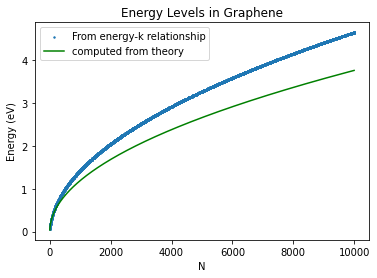

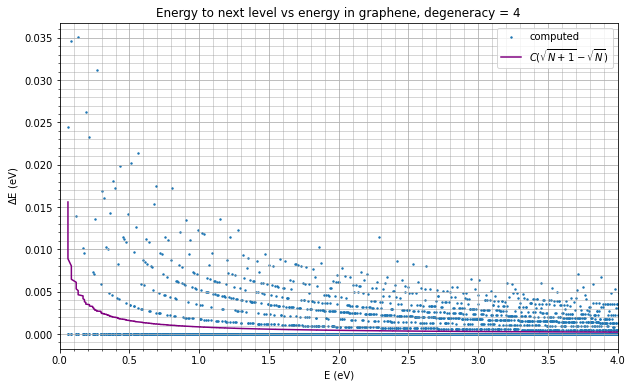

Expected energy scale 0.15369049566643342 meV
9.46581452112805e-21


In [27]:
%matplotlib inline

def E_dE_func(x, a, b):
    return a*np.power(x,b)

def E_dE_regression(energies, energy_diffs):
    coeffs, cov = curve_fit(E_dE_func, energies, energy_diffs
                            ,bounds = ((0,-np.inf),(np.inf,0))
                            ,p0 = [.1,-1]
    )
    a,b = coeffs
    fitted = lambda x, a=a, b=b: E_dE_func(x, a, b)
    return fitted, coeffs

def N_dE_func(x, a):
    return a*(np.sqrt(x+np.ones(len(x)))-np.sqrt(x))

def N_dE_regression(Ns, energy_diffs):
    coeffs, cov = curve_fit(N_dE_func, np.array(Ns), np.array(energy_diffs)

    )
    a = coeffs
    fitted = lambda x, a=a: N_dE_func(x, a)
    return fitted, coeffs

if not numeric_only:
    print("Evaluating pairs for analytic solution")
    energies = []
    for n, l in tqdm(pairs):
        energies.append(hbar**2/2/m_e/R**2/1.6e-19 * js[l-1][n]**2)
        energies.append(hbar**2/2/m_e/R**2/1.6e-19 * js[-l][n]**2)
    energies.sort()
    energies_diffs = 1000*np.array([energies[i+1] - energies[i] for i in range(len(energies)-1)])
    plt.plot(energies_diffs[:100], label="From solving circular well", color='purple')
    plt.xlabel("N")
    plt.ylabel("$\Delta$E meV")
    plt.title("Energy differences for circular well")
    plt.show()


eng_dos = [2*pi*hbar*v_f/(2*R)*sqrt(o)/1.6e-19 for o in tqdm(ordered[:,0])]
eng_dos_diffs = np.array([eng_dos[i+1] - eng_dos[i] for i in range(len(eng_dos)-1)])
Ns = [i+1 for i in range(len(eng_dos_diffs))]
n_dE_fit, coeffs = N_dE_regression(Ns, eng_dos_diffs)
print("Fitted C, ", coeffs)
A = pi*(R)**2
c= 2*hbar/1.6e-19*v_f*sqrt(pi/A)
print("Compute C", c)
n_dE_fit = lambda x, a=c: N_dE_func(x, a)


fitted_dE = n_dE_fit(Ns)
plt.scatter([i+1 for i in range(len(eng_dos))], eng_dos, label = "From energy-k relationship", s=2)
plt.plot(c*np.sqrt(Ns),label="computed from theory", color="green")

plt.title("Energy Levels in Graphene")
plt.xlabel("N")
plt.ylabel("Energy (eV)")
plt.legend()
plt.savefig("graphs/graphene energy levels")
plt.show()

fig = plt.figure(figsize=(10,6))
plt.title("Energy to next level vs energy in graphene, degeneracy = {}".format(spin_degeneracy))
plt.xlabel("E (eV)")
plt.ylabel("$\Delta$E (eV)")


plt.scatter(eng_dos[:-1],eng_dos_diffs, label="computed", s=2)



fit, coeffs = E_dE_regression(eng_dos[:-1], eng_dos_diffs)
domain = np.linspace(eng_dos[0], eng_dos[-2], 5000)
# plt.plot(domain, fit(domain),
#          label = "$\dfrac{a}{x^b}$", color="green")

plt.plot(eng_dos[:-1], fitted_dE, color="purple",
         label = "$C(\sqrt{N+1} - \sqrt{N})$")

# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0,4)
plt.grid()
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.5)
plt.legend()
plt.savefig("graphs/E vs delta E")
plt.show()

print("Expected energy scale {} meV".format(hbar**2*pi**2/m_e/(2*R)**2/1.6e-19*1000))

print(hbar*v_f*2*pi/2/R)